If not already done, install [astroquery](https://astroquery.readthedocs.io) and [GaiaXPy](https://gaia-dpci.github.io/GaiaXPy-website/)

In [ ]:
!pip install astroquery
!pip install GaiaXPy

In [1]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np

# Table of contents
- [RVS Spectra](#rvs)
- [XP Spectra with GaiaXPy](#xp)
    - [Example on two white dwarfs](#WD)
    - [How to change the default sampling](#sampling)
    - [Generate synthetic photometry](#synthphot)

## RVS Spectra <a name="rvs"></a>

Let's select three different type of stars and look for their RVS spectra

In [2]:
RVSsourceIds = ["25276196070213760", "2267193732388859776", "5611353606626845184"]
RVSsourceLabels = ["solar-type","hot star","very cool star"]

In [3]:
rvsdatalink = Gaia.load_data(ids=RVSsourceIds, retrieval_type='RVS', data_structure = 'COMBINED', output_file = None)
rvsdatalink.keys()

dict_keys(['RVS_COMBINED.xml'])

In [4]:
dl_key      = list(rvsdatalink.keys())[0]
tables      = [product.to_table() for product in rvsdatalink[dl_key]]

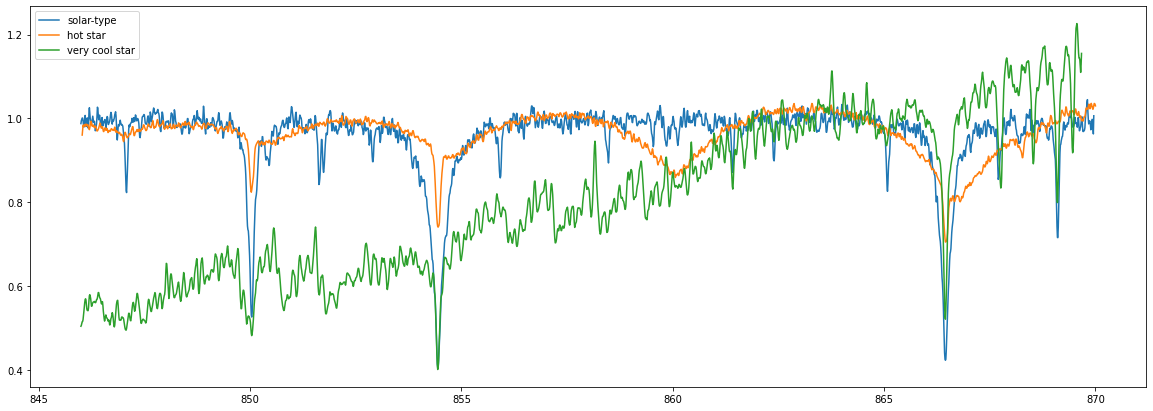

In [5]:
plt.figure(figsize=[20,7])
for rvsspectra in tables:
    plt.plot(rvsspectra['wavelength'], rvsspectra['flux'], '-')
    plt.gca().legend(RVSsourceLabels)
plt.show()

## XP spectra with GaiaXPy <a name="xp"></a>

See also https://gaia-dpci.github.io/GaiaXPy-website/tutorials/

In [6]:
from gaiaxpy import calibrate
from gaiaxpy import plot_spectra

### Example on two white dwarfs <a name="WD"></a>

Let's select two different white dwarfs, a hydrogen-dominated atmosphere one (DA) and a helium-dominated one (DB)

In [7]:
WDsourceIds = ["3489719481290397696", "691116660913783936"] # from 2023arXiv230807090G

GaiaXPy calibrate function can both download the datalink XP_CONTINUOUS spectra and calibrate it to get the equilavent of a XP_SAMPLED spectra directly: 

In [8]:
calibrated_spectra, sampling = calibrate(WDsourceIds)

                                                         0/2 [00:00<?, ?spec/s]

In [9]:
calibrated_spectra

,source_id,flux,flux_error
0,3489719481290397696,"[4.64815322492067e-16, 4.636064362754639e-16, ...","[1.6415168618539022e-17, 1.351674594286787e-17..."
1,691116660913783936,"[1.4387266612687109e-16, 1.499900253064297e-16...","[8.378779573381894e-18, 7.149553343376502e-18,..."


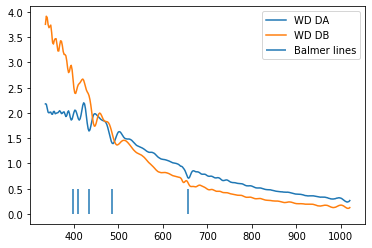

In [10]:
plt.plot(sampling,calibrated_spectra.loc[0,"flux"]/np.mean(calibrated_spectra.loc[0,"flux"]))
plt.plot(sampling,calibrated_spectra.loc[1,"flux"]/np.mean(calibrated_spectra.loc[1,"flux"]))
plt.vlines([656.3,486.1,434.0,410.2,397.0],0,0.5) # Balmer lines
plt.gca().legend(["WD DA", "WD DB","Balmer lines"])
plt.show()

### How to change the default sampling <a name="sampling"></a>

If you do not want GaiaXPy to load the XP_CONTINUOUS spectra twice for this exercice, download the XP_CONTINUOUS yourself and give it as input to the GaiaXPy calibrate method: 

In [11]:
xpdatalink = Gaia.load_data(ids="2342674179138734080", retrieval_type='XP_CONTINUOUS', 
                            format='csv', data_structure = 'RAW')

In [12]:
continuoustable = xpdatalink[list(xpdatalink.keys())[0]][0].to_pandas()
continuoustable

,source_id,solution_id,bp_basis_function_id,bp_degrees_of_freedom,bp_n_parameters,bp_n_measurements,bp_n_rejected_measurements,bp_standard_deviation,bp_chi_squared,bp_coefficients,...,rp_n_parameters,rp_n_measurements,rp_n_rejected_measurements,rp_standard_deviation,rp_chi_squared,rp_coefficients,rp_coefficient_errors,rp_coefficient_correlations,rp_n_relevant_bases,rp_relative_shrinking
0,2342674179138734080,4545469030156206080,56,1332,55,1387,7,1.087727,1575.9542,"(12069.743418372067, -992.2948578438177, -349....",...,55,2776,22,1.060711,3061.4177,"(14034.548086953931, -1529.2438732338364, -12....","(3.3225465, 3.186925, 3.0336554, 3.3824296, 3....","(-0.078817695, 0.103364155, 0.16414402, 0.0176...",9,0.999999


The sampling of the spectra can be tailored to the needs of specific science cases. 
Here we test a sampling spaced evenly on a log scale and compare it with the default sampling (which is np.arange(336., 1021., 2.):

In [13]:
spectra_default, default_sampling = calibrate(continuoustable)
spectra_geom, geom_sampling = calibrate(continuoustable, sampling=np.geomspace(min(default_sampling),max(default_sampling), default_sampling.size))

                                                         0/1 [00:00<?, ?spec/s]

                                                         0/1 [00:00<?, ?spec/s]

Now that you have both sampled spectra generated, you can use the GaiaXPy methods to plot the spectra and associated uncertainties:

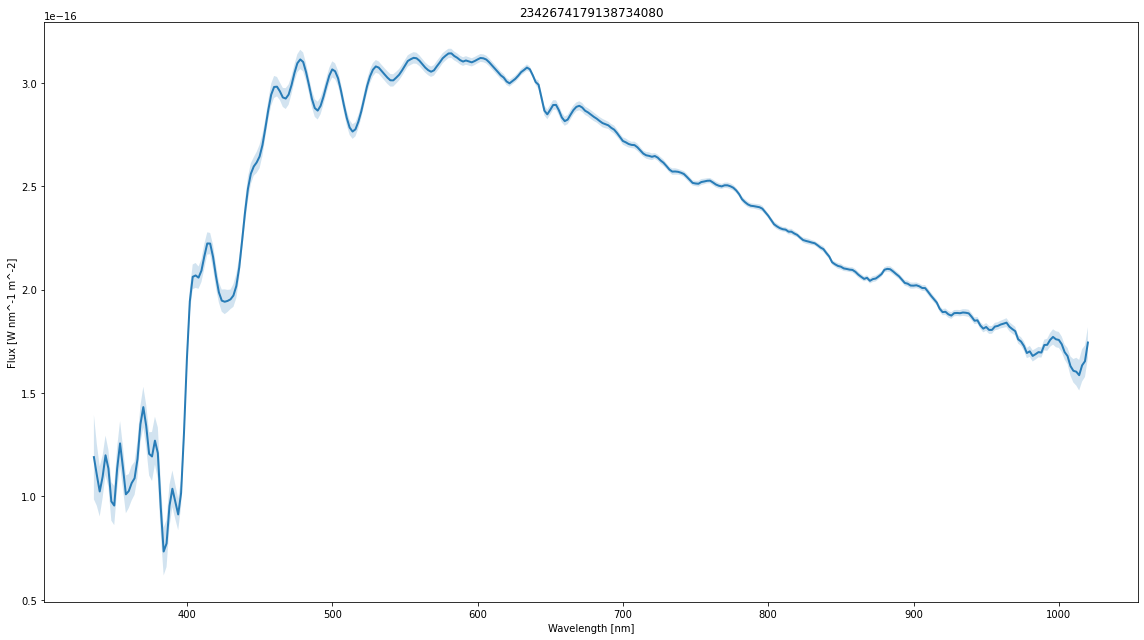

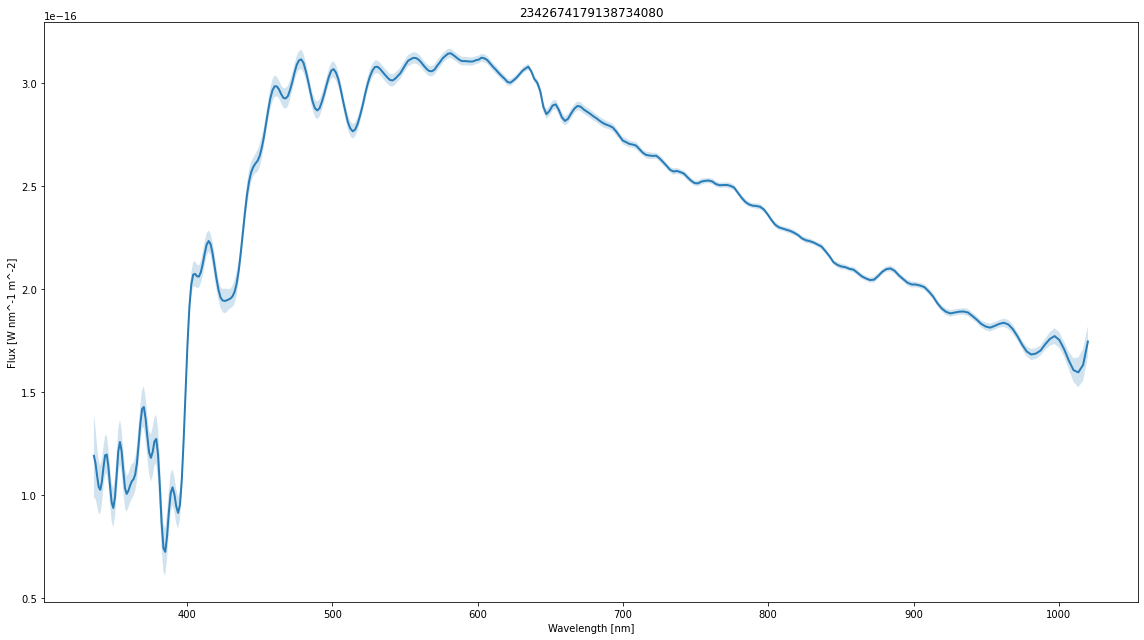

In [14]:
plot_spectra(spectra_default, sampling=sampling)
plot_spectra(spectra_geom, sampling=geom_sampling)

### Generate synthetic photometry <a name="synthphot"></a>


GaiaXPy can generate synthetic photometry for either predefined filter or user defined ones. We will use here predefined ones.

In [15]:
from gaiaxpy import generate, PhotometricSystem
PhotometricSystem.get_available_systems()

'DECam, Els_Custom_W09_S2, Euclid_VIS, Gaia_2, Gaia_DR3_Vega, Halpha_Custom_AB, H_Custom, Hipparcos_Tycho, HST_ACSWFC, HST_HUGS_Std, HST_WFC3UVIS, HST_WFPC2, IPHAS, JKC, JKC_Std, JPAS, JPLUS, JWST_NIRCAM, LSST, PanSTARRS1, PanSTARRS1_Std, Pristine, SDSS, SDSS_Std, Sky_Mapper, Stromgren, Stromgren_Std, WFIRST'

In [16]:
query_input = "select TOP 5 source_id from gaiadr3.gaia_source where has_xp_continuous = 'True'"
phot_system_list = [PhotometricSystem.Stromgren, PhotometricSystem.SDSS]
synthetic_photometry = generate(query_input, photometric_system=phot_system_list, error_correction=True)
synthetic_photometry

INFO: Query finished. [astroquery.utils.tap.core]


                                                           0/2 [00:00<?, ?syst/s]/s]

,source_id,Stromgren_mag_u,Stromgren_mag_v,Stromgren_mag_b,Stromgren_mag_y,Stromgren_flux_u,Stromgren_flux_v,Stromgren_flux_b,Stromgren_flux_y,Stromgren_flux_error_u,...,Sdss_flux_u,Sdss_flux_g,Sdss_flux_r,Sdss_flux_i,Sdss_flux_z,Sdss_flux_error_u,Sdss_flux_error_g,Sdss_flux_error_r,Sdss_flux_error_i,Sdss_flux_error_z
0,5937144193346721408,17.288009,18.301150,17.975435,17.240680,3.899027e-18,3.527443e-18,3.707028e-18,4.591217e-18,6.950651e-19,...,1.517465e-30,2.685247e-30,6.924480e-30,1.112298e-29,1.533698e-29,1.868269e-31,3.162775e-32,4.093318e-32,4.420203e-32,1.631894e-31
1,5937144193346721920,NaN,20.438242,18.996737,18.131302,-1.271968e-19,4.927460e-19,1.447122e-18,2.021525e-18,6.167675e-19,...,-7.723855e-32,9.658365e-31,3.169603e-30,5.208581e-30,7.549418e-30,1.596533e-31,2.154075e-32,2.735645e-32,3.114467e-32,8.025530e-32
2,5937144197664637184,18.503603,20.318796,19.036494,18.182655,1.272679e-18,5.500492e-19,1.395091e-18,1.928137e-18,6.719924e-19,...,2.664984e-31,8.705165e-31,3.067695e-30,4.999721e-30,7.216859e-30,1.729435e-31,2.138101e-32,2.883074e-32,3.088943e-32,8.525114e-32
3,5937144197664673408,18.238153,18.956170,18.020991,17.559431,1.625171e-18,1.929531e-18,3.554706e-18,3.423163e-18,8.008302e-19,...,6.494314e-31,2.216179e-30,5.472295e-30,1.228912e-29,1.791033e-29,2.159065e-31,8.061063e-32,1.380896e-31,1.763980e-31,7.668099e-31
4,5937173266047606784,19.540458,20.135620,18.595040,17.532527,4.897526e-19,6.511362e-19,2.095000e-18,3.509046e-18,6.015676e-19,...,2.047025e-31,1.435659e-30,6.347856e-30,1.352720e-29,2.289377e-29,1.591618e-31,2.776185e-32,3.955779e-32,5.555864e-32,1.503414e-31
